# Generate plots of monthly quality
In this notebook, we'll be generating the article quality trend plots of the entirity of Wikipedia and just articles that fall under the perview of [WikiProject Women Scientists](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Women_scientists).  

This notebook proceeds in 3 main stages.

1. Setup and data loading
2. Plot "weighted_sum" scores overall
3. Plot the proportion of class predictions

## 1: Setup and data loading
In this step, we'll ensure that we have a ggplot2 and data.table libraries installed and loaded.  Then we'll move on to loading in the aggregate monthly statistics for Wikipedia and WikiProject Women Scientists.  This section concludes with small snippet of data from the datasets.

In [1]:
#install.packages("ggplot2")
#install.packages("data.table")
library(ggplot2)
library(data.table)

In [2]:
allwiki.mq = data.table(read.table("../data/processed/enwiki.full_wiki_aggregation.tsv", sep="\t", quote="", header=T))
ws.mq = data.table(read.table("../data/processed/enwiki.wikiproject_women_scientists_aggregation.tsv", sep="\t", quote="", header=T))

allwiki.mq$group = "all wiki"
allwiki.mq$possible_n = max(allwiki.mq$n)
ws.mq$group = "women scientist"
ws.mq$possible_n = max(ws.mq$n)

mq = rbind(allwiki.mq, ws.mq)
mq$month = as.Date(substr(mq$month, 3, 18), format="%Y%m%d")
mq$mean_weighted_sum = (mq$weighted_sum + 1) / mq$possible_n
mq[1:3]

month,weighted_sum,weighted_log_sum,stub_n,start_n,c_n,b_n,ga_n,fa_n,n,group,possible_n,mean_weighted_sum
2001-02-01,18.784,-10.72521,22,0,0,3,0,0,25,all wiki,5206553,3.799827e-06
2001-03-01,98.136,-86.26655,140,3,0,10,0,0,153,all wiki,5206553,1.904062e-05
2001-04-01,333.818,-361.83245,512,36,0,18,0,0,566,all wiki,5206553,6.430704e-05


## 2. Plot "weighted_sum" scores overall
OK.  Now we'll compare the aggregated "weighted_sum" measures for all articles in the different sets.  Here's how the weighted sum is calculated:

```python
CLASS_WEIGHTS = {
  'Stub': 0,
  'Start': 1,
  'C': 2,
  'B': 3,
  'GA': 4,
  'FA': 5
}
def weighted_sum(probabilities):
    return sum(CLASS_WEIGHTS[cls] * proba 
               for cls, proba in probabilities.items())
```

In our previous analysis, we generated a simple arithmetic mean as a centrality measure for article quality predictions for each month.

png 
  2

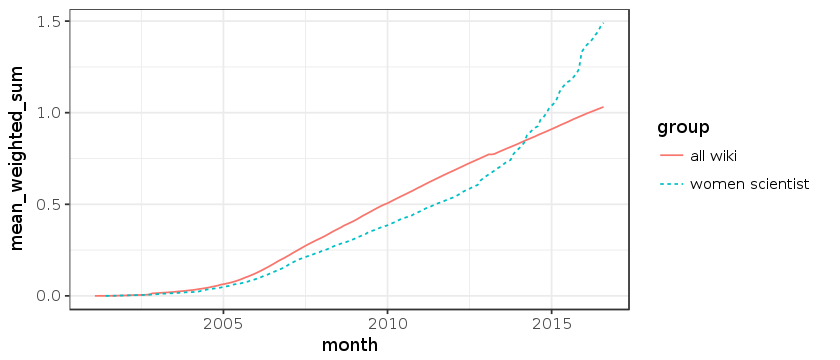

In [3]:
options(repr.plot.height=3)
plot = ggplot(
    mq, aes(month, mean_weighted_sum, linetype=group, color=group)
) + 
theme_bw() + 
geom_line()
print(plot)
svg("../reports/figures/enwiki_mean_weighted_sum.all_and_ws.svg", height=5, width=7)
print(plot)
dev.off()

Here, we can see a clear trend in the expected "weighted_sum" quality of articles in each set.  While overall, Wikipedia shows a linear growth since 2005, WikiProject Women Scientists articles shows a sudden shift around mid-2013.  After this point, it seems that the quality level of articles about women scientists grows much more quickly than the rest of the encyclopedia.

## 3. Plot the proportion of class predictions
The arithmetic mean provides a nice way to look at overall quality, but where were the quality changes happening?  Where Stubs being converted to Start?  Are GAs becoming FAs?  In this section, we'll compare the proportion of articles that fall into each quality class prediction over time.

In [4]:
mq.by_prediction = rbind(
    mq[,list(month=month, group=group, possible_n=possible_n, prediction="Empty", n=possible_n-(stub_n+start_n+c_n+b_n+ga_n+fa_n)),],
    mq[,list(month=month, group=group, possible_n=possible_n, prediction="Stub", n=stub_n),],
    mq[,list(month=month, group=group, possible_n=possible_n, prediction="Start", n=start_n),],
    mq[,list(month=month, group=group, possible_n=possible_n, prediction="C", n=c_n),],
    mq[,list(month=month, group=group, possible_n=possible_n, prediction="B", n=b_n),],
    mq[,list(month=month, group=group, possible_n=possible_n, prediction="GA", n=ga_n),],
    mq[,list(month=month, group=group, possible_n=possible_n, prediction="FA", n=fa_n),]
)
mq.by_prediction$prediction = ordered(mq.by_prediction$prediction, levels=c("Empty", "Stub", "Start", "C", "B", "GA", "FA"))




png 
  2

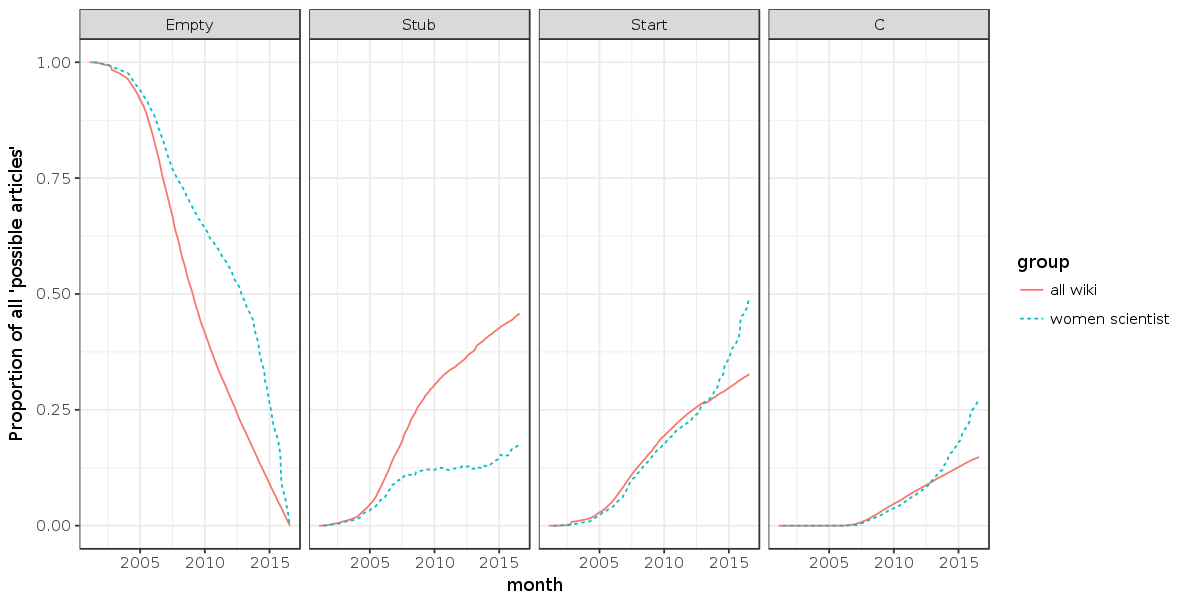

In [5]:
options(repr.plot.height=5, repr.plot.width=10)
plot = ggplot(
    mq.by_prediction[prediction %in% c("Empty", "Stub", "Start", "C"),],
    aes(x=month, y=n/possible_n, linetype=group, color=group)
) + 
theme_bw() + 
facet_wrap(~prediction, nrow=1) + 
geom_line() + 
scale_y_continuous("Proportion of all 'possible articles'")
print(plot)
svg("../reports/figures/enwiki_proportion_of_class.empty2c.all_and_ws.svg", height=5, width=7)
print(plot)
dev.off()

In the plot above, we can see some clear differences between Wikipedia overall and articles about Women Scientists.  The "Empty" cell shows the proportion of articles that exist at the end of our observations ("possible_n") that were not yet created.  Here, we can see that the rate of creation of articles for all of Wikipedia is much faster than the rate of creation of Women Scientist articles until mid-2013.

Surprisingly, the "Stub" cell show that Wikipedia generally saw a steady growth of Stubs whereas Women Scientists saw period growth.  Between 2004 and 2009, Women Scientist Stubs grew steadily, but then stopped until mid-2013 when there was a sudden up-tick that continues until the end of our data (Aug 2016). 

The creation (or promotion) of Women Scientist articles to Start class runs much more in-step with the rest of Wikipedia for most of its history, but it shows a suddent growth around beginning of 2013.  A similar trend plays out in "C" class articles.  

png 
  2

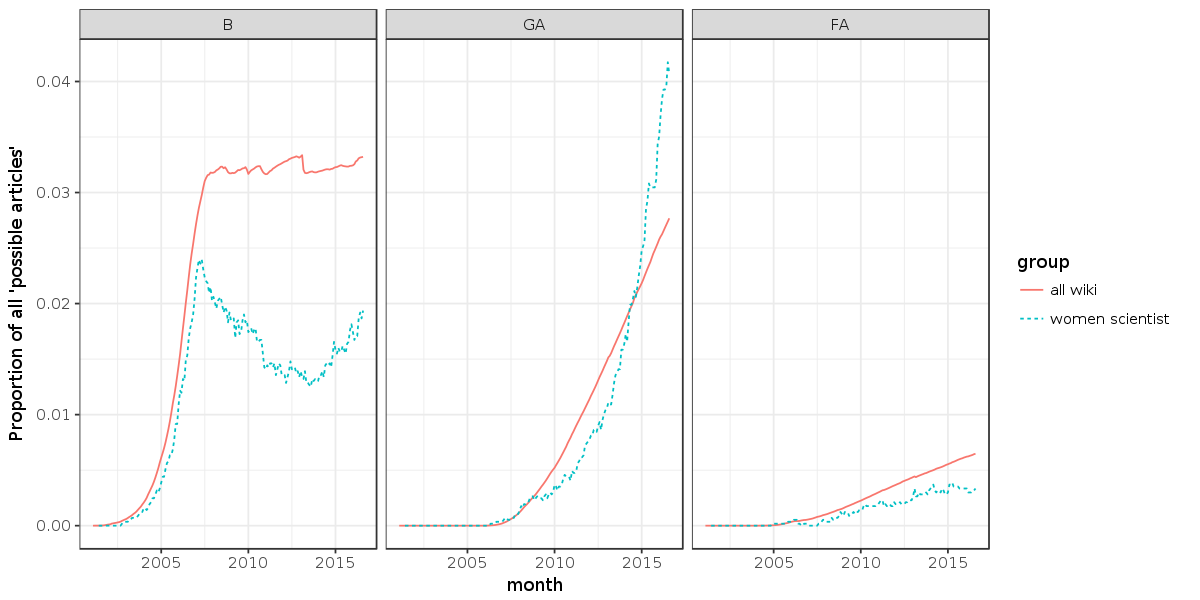

In [6]:
plot = ggplot(
    mq.by_prediction[prediction %in% c("B", "GA", "FA"),],
    aes(x=month, y=n/possible_n, linetype=group, color=group)
) + 
theme_bw() + 
facet_wrap(~prediction, nrow=1) + 
geom_line() + 
scale_y_continuous("Proportion of all 'possible articles'")
print(plot)
svg("../reports/figures/enwiki_proportion_of_class.b2fa.all_and_ws.svg", height=5, width=7)
print(plot)
dev.off()

The proportion of articles falling to "B" class shows a dramatically different trend for all Wikipedia (exponential growth with an abrupt stop in 2007) and articles about women scientists (eponential growth until 2007, followed by a sharp decline to a valley between 2011 and 2014 and recovery).  The proportion of GA articles largely tracks overall Wikipedia, though there's a smaller proportion of GA class women scientist articles between 2007 and 2013 followed by a dramatically higher proportion from 2013 forward.  The FA class cell shows the proportion of FA (Wikipedia's highest quality class) articles about women scientists has been consistently lower than the rest of the encyclopedia.  